# Imports

In [16]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data

In [2]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

indicator = 'calcium'
database.connect_dj(indicator=indicator)
clear_output()

In [3]:
morph_tab = database.get_morph_tab()
field_tab = database.get_field_tab()

# Select data

# Plot

In [4]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [5]:
FIGURE_FOLDER = './figures/'

# Select example cells

In [6]:
cell_keys = [
    dict(date="2020-06-08", exp_num=1),
    dict(date="2020-05-11", exp_num=1),
]

# Plot stacks

## Steps

In [7]:
if indicator == 'calcium':
    norm_stack_kw = dict(q1_low=60, q1_high=0.025, q2_low=0.5, q2_high=0.0001)
    proj_z_kw = dict(gamma0=1., gamma1=0.8, gammaz=2., offz=1.)
else:
    norm_stack_kw = dict(q2_low=60, q2_high=0.1, q1_low=0.5, q1_high=0.0001)
    proj_z_kw = dict(gamma1=1., gamma0=0.8, gammaz=2., offz=1.)

In [8]:
from djimaging.utils import scanm_utils


def get_norm_stack(filepath, q1_low=7.5, q1_high=0.025, q2_low=0.5, q2_high=0.0001):
    ch_stacks = scanm_utils.load_stacks_from_h5(filepath)[0]
    norm_stack0 = plota.normalize_stack(ch_stacks['wDataCh0'], q_low=q1_low, q_high=q1_high)
    norm_stack1 = plota.normalize_stack(ch_stacks['wDataCh1'], q_low=q2_low, q_high=q2_high)
    return norm_stack0, norm_stack1

In [9]:
c1_filepath, c1_pixel_size = (field_tab & cell_keys[0] & dict(field='stack')).fetch1('fromfile', 'pixel_size_um')
c1_norm_stack0, c1_norm_stack1 = get_norm_stack(c1_filepath, **norm_stack_kw)

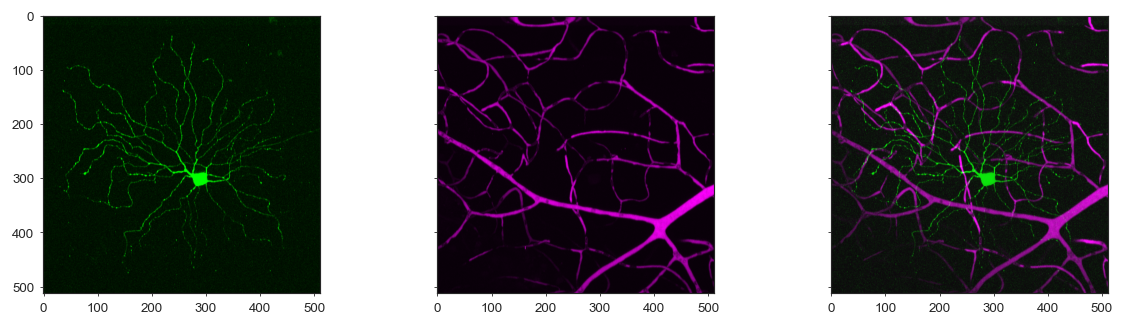

In [10]:
c1_col_z_proj = plota.get_col_z_proj(c1_norm_stack0, c1_norm_stack1, **proj_z_kw, plot=True);

In [11]:
c2_filepath, c2_pixel_size = (field_tab & cell_keys[1] & dict(field='stack')).fetch1('fromfile', 'pixel_size_um')
c2_norm_stack0, c2_norm_stack1 = get_norm_stack(c2_filepath, **norm_stack_kw)

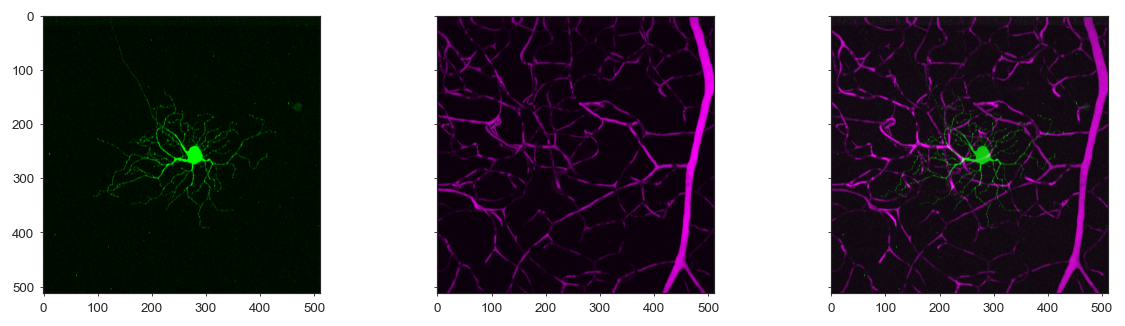

In [12]:
c2_col_z_proj = plota.get_col_z_proj(c2_norm_stack0, c2_norm_stack1, **proj_z_kw, plot=True);

In [13]:
print(c1_pixel_size, c2_pixel_size)

0.664993 0.664993


## Summary

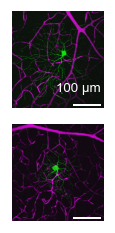

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(1, 2))

for i, (col_z_proj, pixel_size) in enumerate([(c1_col_z_proj, c1_pixel_size), (c2_col_z_proj, c2_pixel_size)]):
    plota.plot_col_z_proj(axs[i], col_z_proj, pixel_size_um=pixel_size)
    axs[i].axis('off')
    plota.plot_scale_bar(axs[i],
                         x0=0.9 * col_z_proj.shape[0] / 2 * pixel_size - 100,
                         y0=-0.93 * col_z_proj.shape[1] / 2 * pixel_size,
                         size=100, pad=+80, text='100 µm' if i == 0 else ' ',
                         orientation='h', color='w', text_ha='right', text_x_pad=50)

plt.tight_layout()
fig.savefig(os.path.join(FIGURE_FOLDER, f'raw_stacks_{indicator}.pdf'), bbox_inches='tight', dpi=600)

## Morph extraction

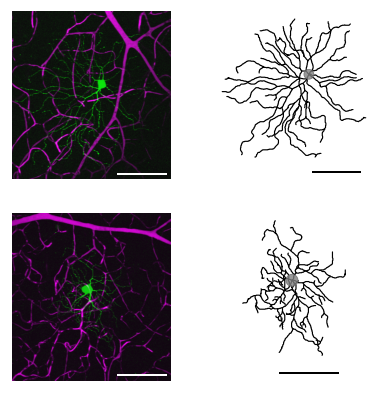

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4))

for i, (cell_key, col_z_proj, pixel_size) in enumerate(
        [(cell_keys[0], c1_col_z_proj, c1_pixel_size), (cell_keys[1], c2_col_z_proj, c2_pixel_size)]):
    ax = axs[i, 0]
    plota.plot_col_z_proj(ax, col_z_proj, pixel_size_um=pixel_size)
    plota.plot_scale_bar(ax,
                         x0=0.9 * col_z_proj.shape[0] / 2 * pixel_size - 100,
                         y0=-0.93 * col_z_proj.shape[1] / 2 * pixel_size,
                         size=100, pad=+60, text=' ', orientation='h', color='w')

    ax.axis('off')

    df_paths, soma_xyz = (morph_tab & cell_key).fetch1('df_paths', 'soma_xyz')
    df_paths = pd.DataFrame(df_paths)
    xyz_min = np.min(np.vstack(df_paths.path), axis=0)
    xyz_max = np.max(np.vstack(df_paths.path), axis=0)

    ax = axs[i, 1]

    plota.plot_paths(ax=ax, paths=df_paths.path, soma_xyz=soma_xyz, lw=0.7)
    plota.plot_scale_bar(ax, x0=xyz_max[0] - 110, y0=xyz_min[1] - 30, size=100, pad=+60, text=' ', orientation='h')

    ax.set_aspect('equal', 'box')
    ax.axis('off')

fig.savefig(os.path.join(FIGURE_FOLDER, f'raw_stacks_and_morph_{indicator}.pdf'), bbox_inches='tight', dpi=600)